In [1]:
import xarray as xr
import numpy as np
import more_itertools as mit
import glob
import datetime as dt 
#import vor_fast
#import vor_fast_setup
import pandas as pd
import sys
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# Constants

In [2]:
plt.rcParams.update({'font.size': 28, "contour.linewidth": 4})
root_path = '/work/bd1022/b381258/CMIP6/'
time_dict = dict(time = slice('1979-01',None))
out_dir = './SSWs_stats/'

In [6]:
filepaths1=[]
for filepath1 in glob.iglob(f'{root_path}*ua*'):
    filepaths1.append(filepath1)
filepaths1.sort()

# filepaths to obtain 10hPa GPH for northern hemisphere
filepaths2=[]
for filepath2 in glob.iglob(f'{root_path}*moments*'):
    filepaths2.append(filepath2)
filepaths2.sort()

In [12]:
model_ls = list(map(lambda x: x.split('.')[2], filepaths2))
model_ls

['CanESM5',
 'CanESM5',
 'CNRM-CM6-1',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'MIROC6',
 'UKESM1-0-LL',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'UKESM1-0-LL',
 'CanESM5',
 'MPI-ESM1-2-LR']

In [236]:
model_ls = list(map(lambda x: x.split('.')[1], filepaths1))
model_ls

['CNRM-CM6-1',
 'CanESM5',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'UKESM1-0-LL']

# SSW frequency

Code adopted from [Hall et al (2021)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JD034759).

In [13]:
for model in ['CNRM-CM6-1']:#model_ls[-1:]:
    print(model)
    filename1 = glob.glob(f'{root_path}*{model}*ua*')[-1]
    DS = xr.open_dataset(filename1,use_cftime=True)
    u10=DS['ua'].sel(**time_dict)#.sel(plev = 1000)
    u10 = u10.squeeze()

    filename2 = glob.glob(f'{root_path}*{model}*moments*')[-1]
    moments = xr.open_dataset(filename2,use_cftime=True).sel(**time_dict).sel(plev = 1000)
    #aspect = moments['aspect_ratio']
    #latcent = moments['centroid_latitude']

    for ens in u10.member_id.values: #sorted
        print(ens)
        temp = u10.sel(member_id = ens)
        try:
            moments_ens = moments.sel(member_id = ens)
            ens_avail = True
        except:
            ens_avail = False
            pass
            #moments_ens

        vortex_class=[]
        SSW_dates=[]
        for (year, temp_sel), (_, moments_ens_sel) in zip(list(temp.groupby('time.year')), list(moments_ens.groupby('time.year'))):

            aspect = np.empty(0)
            latcent = np.empty(0)       

            print(year)   


            idx=np.where(temp_sel<0)

        #group the indices into events
            events=[list(group) for group in mit.consecutive_groups(idx[0])]
            #print(events)
            if not (events):
                print ('no events')
                continue

        # check last event is not a final warming. If it is, remove
            if events[-1][-1] >len(temp_sel)-10:
                del events[-1]
            if not (events):
                print ('no events')
                continue
        # check that there are at least 10 consecutive days of westerlies at some point after last remaining event
            if len(events)==1:
                idx_end=np.where(temp_sel[events[0][-1]+1:-1]>0)
                events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                if len(events_end[0])<10:
                    del events[0]
            else:
                for i in range(len(events)-1,0,-1):
                    idx_end=np.where(temp_sel[events[i][-1]+1:-1]>0)
                    events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                    consec_pos=[]
                    for k in range (0,len(events_end)):
                        length=len(events_end[k])
                        consec_pos.append(length)
                    if all (ele <10 for ele in consec_pos):
                        del events[i]

        # delete any events starting in April or November
            months=[]
            for e in range(0,len(events)):
                mon=int(temp_sel.time[events[e][0]].dt.strftime('%m'))
                months.append(mon)

            remove=[]
            for e in range(0,len(events)):
                if months[e]==4 or months[e]==11:
                    remove.append(e)

            for index in sorted(remove,reverse=True):
                del events[index]
            #print(events)

            if not (events):
                print ('no events')

        #for  events, check if 20 consecutive days of westerlies before events
            remove=[]
            for j in np.arange(len(events)):
                if np.any(temp_sel[events[j][0]-20:events[j][0]]<0):
                    remove.append(j)
            print('to remove= ', remove)

            for index in sorted(remove,reverse=True):
                del events[index]
            #print(events)

            if not (events):
                print ('no events')

        #final check for last event, does it have 10 consecutive days of westerlies afterwards
            if len(events)>0:
                idx_end=np.where(temp_sel[events[-1][-1]+1:-1]>0)
                events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                consec_pos=[]
                for k in range (0,len(events_end)):
                    length=len(events_end[k])
                    consec_pos.append(length)
                if all (ele <10 for ele in consec_pos):
                    del events[-1]

            elif not (events):
                print ('no events')

        #extract the onset dates from the events
            event_length=[]
            start_idx=[]
            for i in range(0,len(events)):
                start=events[i][0]
                length=len(events[i])
                start_idx.append(start)
                event_length.append(length)

            #print('indices of onset dates=',start_idx)
            #print('event lengths=',event_length)

            onset_dates=temp_sel.time[start_idx].values
            print('onset dates =',onset_dates)
            #sys.exit()
            #using vortex moments classify vortex as split, displacement or unclassifiable
            #NB calculate vorTex edge for each model separately and add below
            vortex_ID=[]
            for idx in range(0,len(start_idx)):
                date_ind=start_idx[idx]


                if ens_avail:
                    for iday in range(date_ind-10,date_ind+11):
                        aspect = np.append(aspect, moments_ens_sel['aspect_ratio'].isel(time = iday))
                        latcent = np.append(latcent, moments_ens_sel['centroid_latitude'].isel(time = iday))

                    #print(aspect)
                    #print(latcent)
                    aspect_days=np.count_nonzero(aspect>2.4)
                    latcent_days=np.count_nonzero(latcent<66)
                    print('days above aspect threshold=',aspect_days)
                    print('days below latcent threshold=',latcent_days)
                    vortex_type=[]
                    if aspect_days > latcent_days:
                        vortex_type ="split"
                    elif aspect_days < latcent_days:
                        vortex_type = "displaced"
                    else:
                        vortex_type = "unclassified"

                    #print(vortex_type)
                    #continue
                else:
                    vortex_type =  f'{ens} N/A'


                vortex_ID.append(vortex_type)

            SSW_dates.extend(onset_dates)
            vortex_class.extend(vortex_ID)

            #sys.exit()
        print('SSW dates are:',SSW_dates)
        print('vortex types:', vortex_class)
        print(len(SSW_dates))

        # make dataframe of results for model
        model_SSWs=pd.DataFrame()
        model_SSWs['onset dates']=SSW_dates
        model_SSWs['vortex type']=vortex_class
        model_SSWs.to_csv(f'{out_dir}{model}_{ens}.csv')
        
        split_model=model_SSWs[(model_SSWs['vortex type']=='split')]
        disp_model=model_SSWs[(model_SSWs['vortex type']=='displaced')]
        unclass_model=model_SSWs[(model_SSWs['vortex type']=='unclassified')]
        unavail_model=model_SSWs[(model_SSWs['vortex type']==f'{ens} N/A')]

        split_dates=np.array(split_model['onset dates'])
        disp_dates=np.array(disp_model['onset dates'])
        unclass_dates=np.array(unclass_model['onset dates'])
        unavail_dates=np.array(unavail_model['onset dates'])

        #save SSW dates as .npy files for use in subsequent code.
        np.save(f'{out_dir}{model}_{ens}_split_dates_all.npy',split_dates)
        np.save(f'{out_dir}{model}_{ens}_disp_dates_all.npy',disp_dates)
        np.save(f'{out_dir}{model}_{ens}_unclass_dates_all.npy',unclass_dates)
        np.save(f'{out_dir}{model}_{ens}_all_SSW_dates.npy',SSW_dates)

        print('number of displacements: ',len(disp_dates))
        print('number of splits: ',len(split_dates))
        print('number of unclassified: ',len(unclass_dates))
        print('number of N/A: ',len(unavail_dates))

CNRM-CM6-1
r6i1p1f2
1979
to remove=  [1]
onset dates = [cftime.DatetimeProlepticGregorian(1979, 2, 24, 12, 0, 0, 0, has_year_zero=True)]
days above aspect threshold= 10
days below latcent threshold= 0
1980
to remove=  [1]
onset dates = [cftime.DatetimeProlepticGregorian(1980, 2, 18, 12, 0, 0, 0, has_year_zero=True)]
days above aspect threshold= 0
days below latcent threshold= 7
1981
no events
1982
to remove=  []
onset dates = [cftime.DatetimeProlepticGregorian(1982, 3, 29, 12, 0, 0, 0, has_year_zero=True)]
days above aspect threshold= 0
days below latcent threshold= 5
1983
to remove=  [1]
onset dates = [cftime.DatetimeProlepticGregorian(1983, 1, 19, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(1983, 3, 20, 12, 0, 0, 0, has_year_zero=True)]
days above aspect threshold= 9
days below latcent threshold= 10
days above aspect threshold= 11
days below latcent threshold= 12
1984
to remove=  [1]
onset dates = [cftime.DatetimeProlepticGregorian(1984, 2, 25, 12, 0, 0, 0, ha

<AxesSubplot:xlabel='vortex type'>

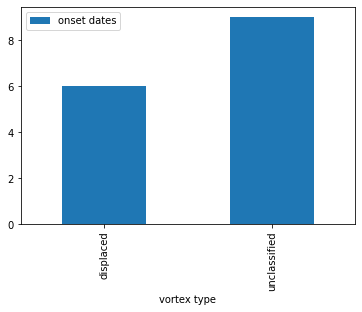

In [141]:
model_SSWs.groupby('vortex type').count().plot.bar()

# Modes calculation

In [14]:
def mode_func(aspect, latcent):
    #for latcent, cube the values to transform the distribution
    latcent3=np.power(latcent,3)
    #fit Gaussian distribution and use KS test for fit
    dist=getattr(stats,'norm')
    parameters=dist.fit(latcent3)
    (mean,SD)=parameters
    ks_stat,ks_pval=stats.kstest(latcent3,"norm",parameters)
    # convert latitude back (cube root)
    mode=np.power(mean,1/3)

    print('latcent mode:',mode)
    print('norm KS statistic and p value:',ks_stat,ks_pval)

    #fit GEV to aspect data
    dist2=getattr(stats,'genextreme')
    parameters=dist2.fit(aspect)
    (shape,location,scale)=parameters
    ks_stat_GEV,ks_pval_GEV = stats.kstest(aspect,"genextreme",parameters)

    print('location:', location)
    print(' GEV KS statistic and p value:',ks_stat_GEV,ks_pval_GEV)

    #aspect mode calculated according to Seviour et al. 2016 (S16)
    asp_params=stats.genextreme.fit(aspect)
    asp_pdf=stats.genextreme.pdf(aspect,asp_params[0],loc=asp_params[1],scale=asp_params[2])
    index=np.argmax(asp_pdf)
    max_asp_S16=aspect[index]

    print ('S16 aspect:',max_asp_S16)

    #kde alternative
    # aspect
    min_val=1
    max_val=int(np.round(np.max(aspect))+1)
    
    divs=(max_val-min_val)*100
    
    asp_xs=np.linspace(min_val,max_val,divs)
    asp_density=stats.gaussian_kde(aspect)
    asp_ys=asp_density(asp_xs)
    index=np.argmax(asp_ys)
    max_asp_kde=asp_xs[index]

    #latcent
    min1=int(np.round(np.min(latcent))-1)
    max1=90
    divs1=(max1-min1)*100

    lat_xs=np.linspace(min1,max1,divs1)
    lat_density=stats.gaussian_kde(latcent)
    lat_ys=lat_density(lat_xs)
    index1=np.argmax(lat_ys)
    max_lat_kde=lat_xs[index1]

    print ('kde aspect:',max_asp_kde)
    print ('kde latcent:',max_lat_kde)
    
    return max_asp_S16,mode

def diff_list(x, wo_x):
    return list(set(x) - set(wo_x))

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [15]:
for model in ['CNRM-CM6-1']:#model_ls[:]:
    print(model)

    filename2 = glob.glob(f'{root_path}*{model}*moments*')[-1]
    moments = xr.open_dataset(filename2,use_cftime=True).sel(**time_dict).sel(plev = 1000)
    #aspect = moments['aspect_ratio']
    #latcent = moments['centroid_latitude']

    mode_aspect_ls = []
    mode_latcent_ls = []
    for ens in sorted(moments.member_id.values):  
        print(ens)
        moments_ens = moments.sel(member_id = ens)
        
        aspect = moments_ens['aspect_ratio']
        latcent =  moments_ens['centroid_latitude']
        
        aspect=aspect[np.logical_not(np.isnan(aspect))]
        aspect=aspect[aspect < float('+inf')]
        aspect=aspect[aspect < 100.0]
        latcent=latcent[np.logical_not(np.isnan(latcent))]
        latcent=latcent[latcent < float('+inf')]        
        
        mode_aspect, mode_latcent = mode_func(aspect.values, latcent.values)
        mode_aspect_ls.append(xr.DataArray([mode_aspect], coords = [('ens', [ens])]))
        mode_latcent_ls.append(xr.DataArray([mode_latcent], coords = [('ens', [ens])]))
        print()
        
    
    mode_aspect_da = xr.concat(mode_aspect_ls,dim='ens')
    mode_aspect_da.name = 'mode_aspect'
    mode_latcent_da = xr.concat(mode_latcent_ls,dim='ens')
    mode_latcent_da.name = 'mode_latcent'  
    
    ds_mode = xr.merge([mode_aspect_da, mode_latcent_da])
    ds_mode.to_netcdf(f'{out_dir}{model}_modes_nc')
    #sys.exit()

CNRM-CM6-1
r11i1p1f2
latcent mode: 77.38179593025174
norm KS statistic and p value: 0.04116846290423204 2.2782279793569566e-08
location: 1.3084448021934767
 GEV KS statistic and p value: 0.023319552613234595 0.005624079414970713
S16 aspect: 1.2631679206365964
kde aspect: 1.2702251876563804
kde latcent: 78.71754729288975

r12i1p1f2
latcent mode: 77.44744344263424
norm KS statistic and p value: 0.039052915668476906 1.3089346390424525e-07
location: 1.3089978639409736
 GEV KS statistic and p value: 0.019588178678033752 0.030992772492491327
S16 aspect: 1.2559745590236338
kde aspect: 1.2902418682235197
kde latcent: 79.70785580329235

r13i1p1f2
latcent mode: 78.64274963925834
norm KS statistic and p value: 0.0585731656691621 1.3302461970136403e-16
location: 1.3101943050895455
 GEV KS statistic and p value: 0.020211496652438155 0.0235666705390357
S16 aspect: 1.2570510513077504
kde aspect: 1.2804005722460658
kde latcent: 80.13823897124487

r14i1p1f2
latcent mode: 77.60787968848564
norm KS stati

# Visualization

In [16]:
model_ls_new = [
    'CNRM-CM6-1', 'MPI-ESM1-2-HR', 
    'MPI-ESM1-2-LR', 'UKESM1-0-LL','MIROC6',
    'INM-CM5-0','IPSL-CM6A-LR','ERA5','CESM2-LE', 'CanESM5',
]

CNRM-CM6-1
CanESM5
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
IPSL-CM6A-LR
INM-CM5-0
CESM2-LE
ERA5


<AxesSubplot:>

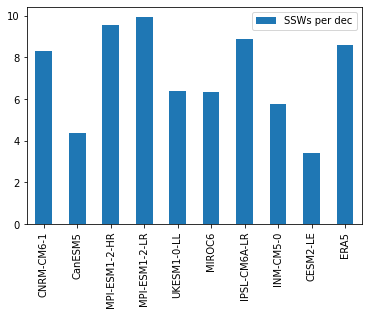

In [84]:
df_g = []
how = ['split','displaced','unclassified']
ny = 36 # between 1979 and 2014

total_ls = []
for model_i, (model, color) in enumerate(zip(model_ls_new, color_ls)):
    print(model)
    if model != 'ERA5':
        infiles = glob.glob(f'{out_dir}{model}_*.csv')
        n_files = len(infiles)
        df = pd.concat(map(pd.read_csv, infiles))
        total = df.groupby('vortex type').count().loc[:,'onset dates'].sum()/ny/n_files*10
    else:
        df = pd.read_csv(f'{out_dir}{model}.csv')
        total = df.groupby('vortex type').count().loc[:,'onset dates'].sum()/ny*10
    total_ls.append(total)#{f'{model}':total})
    #df_g = df.groupby('vortex type').count().loc[how,'onset dates']/36/n_files
    #df_g_ls.append(df_g)
    #sys.exit()
df = pd.DataFrame(total_ls, index = model_ls_new, columns = ['SSWs per dec'])
df.plot.bar()

CNRM-CM6-1
CanESM5
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
IPSL-CM6A-LR
INM-CM5-0
CESM2-LE
ERA5


<AxesSubplot:>

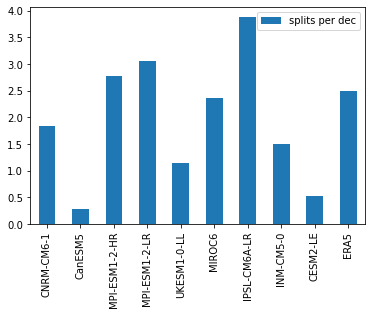

In [87]:
df_g = []
how = ['split','displaced','unclassified']
ny = 36 # between 1979 and 2014

index = 0

total_ls = []
for model_i, (model, color) in enumerate(zip(model_ls_new, color_ls)):
    print(model)
    if model != 'ERA5':
        infiles = glob.glob(f'{out_dir}{model}_*.csv')
        n_files = len(infiles)
        df = pd.concat(map(pd.read_csv, infiles))
        total = df.groupby('vortex type').count().loc[how[index],'onset dates'].sum()/ny/n_files*10
    else:
        df = pd.read_csv(f'{out_dir}{model}.csv')
        total = df.groupby('vortex type').count().loc[how[index],'onset dates'].sum()/ny*10
    total_ls.append(total)#{f'{model}':total})
    #df_g = df.groupby('vortex type').count().loc[how,'onset dates']/36/n_files
    #df_g_ls.append(df_g)
    #sys.exit()
df = pd.DataFrame(total_ls, index = model_ls_new, columns = [f'{how[index]}s per dec'])
df.plot.bar()

CNRM-CM6-1
CanESM5
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
IPSL-CM6A-LR
INM-CM5-0
CESM2-LE
ERA5


<AxesSubplot:>

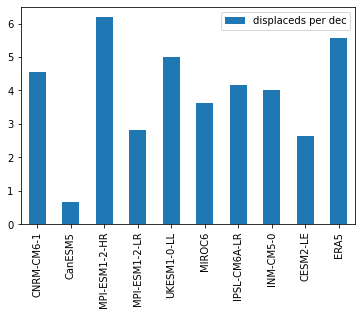

In [88]:
df_g = []
how = ['split','displaced','unclassified']
ny = 36 # between 1979 and 2014

index = 1

total_ls = []
for model_i, (model, color) in enumerate(zip(model_ls_new, color_ls)):
    print(model)
    if model != 'ERA5':
        infiles = glob.glob(f'{out_dir}{model}_*.csv')
        n_files = len(infiles)
        df = pd.concat(map(pd.read_csv, infiles))
        total = df.groupby('vortex type').count().loc[how[index],'onset dates'].sum()/ny/n_files*10
    else:
        df = pd.read_csv(f'{out_dir}{model}.csv')
        total = df.groupby('vortex type').count().loc[how[index],'onset dates'].sum()/ny*10
    total_ls.append(total)#{f'{model}':total})
    #df_g = df.groupby('vortex type').count().loc[how,'onset dates']/36/n_files
    #df_g_ls.append(df_g)
    #sys.exit()
df = pd.DataFrame(total_ls, index = model_ls_new, columns = [f'{how[index]}s per dec'])
df.plot.bar()

In [76]:
df = pd.DataFrame([total_ls], columns = model_ls_new)
df

,CNRM-CM6-1,CanESM5,MPI-ESM1-2-HR,MPI-ESM1-2-LR,UKESM1-0-LL,MIROC6,IPSL-CM6A-LR,INM-CM5-0,CESM2-LE,ERA5
0,8.333333,4.365079,9.555556,9.937276,6.388889,6.333333,8.862007,5.777778,3.424036,8.611111


<AxesSubplot:>

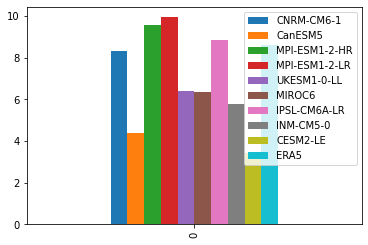

In [78]:
df.plot.bar()

<AxesSubplot:xlabel='vortex type'>

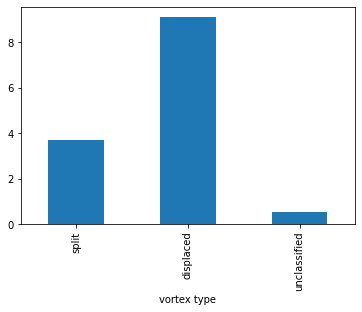

In [40]:
how = ['split','displaced','unclassified']
df_g = df.groupby('vortex type').count().loc[how,'onset dates']/36#['vortex type' in ['split',]]#.plot.bar()
df_g.plot.bar(stacked=True)

## Splits

In [19]:
plt.rcParams.update({'font.size': 28, "contour.linewidth": 4})


CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
ERA5
CESM2-LE
CanESM5
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.737   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.700   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     19.64   \\
\textbf{Date:}             & Thu, 04 May 2023 & \textbf{  Prob (F-statistic):} &  0.00304    \\
\textbf{Time:}             &     18:23:52     & \textbf{  Log-Likelihood:    } &   -7.7065   \\
\textbf{No. Observations:} &           9      & \textbf{  AIC:               } &     19.41   \\
\textbf{Df Residuals:}     &           7      & \textbf{  BIC:               } &     19.81   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &   

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


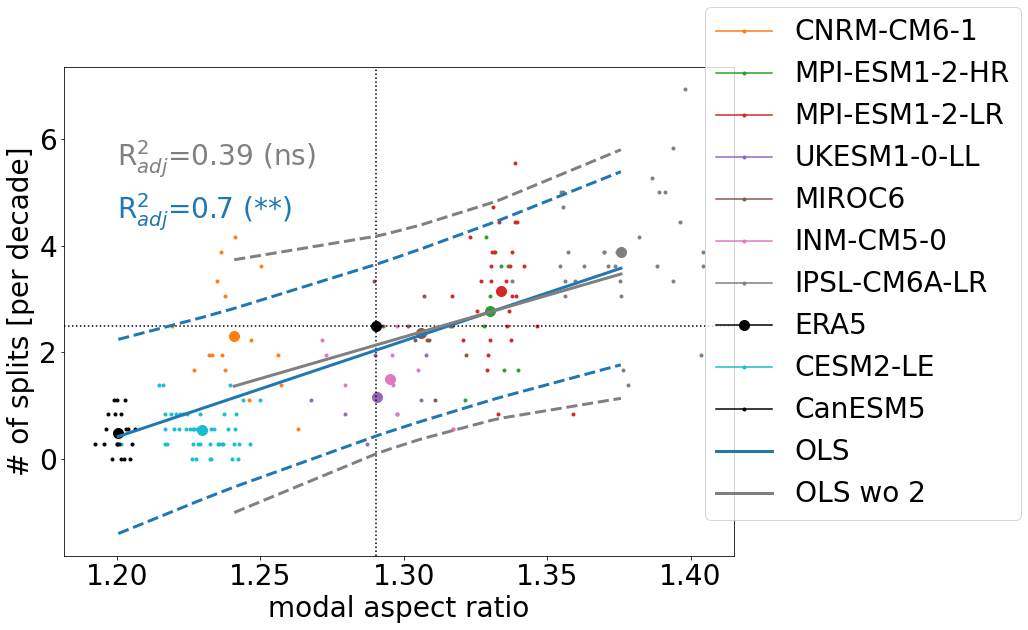

In [23]:
color_ls = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','k']
ny = 36#np.unique(u10.time.dt.year).shape[0]
ms = 10
wo_outliers = True
how_many = 2 # how many last models (outliers) to remove from regression
ols_calc = True
wls_calc = False

fig, ax = plt.subplots(figsize = (12,9))

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []
for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_split_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_aspect'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_split_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_aspect'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        
        x = np.mean(mode_ls)
        y= np.mean(ns_ls)
        y_std= np.var(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        model_ns_var_ls.append(xr.DataArray([y_std], coords = [('model', [model])]))
        ax.plot(x,y, marker = 'o', color = color,ms = ms)

model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T) #  necessary, negative intercept is unphysical (frequancy of events cannot be <0)
y = model_ns_da.values
order = np.argsort(model_mode_da)


# OLS
if ols_calc:
    model_OLS = sm.OLS(y, x1)
    results = model_OLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'OLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)      
    print(results.summary().as_latex())
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[-1])#.round(3)
    ax.text(1.2,4.5,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    #ax.text(1.2,4.5,r"R$^{2}_{adj}$="+f"{r2}", color = 'C0')

if wls_calc:
    model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
    results = model_WLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
    ax.text(1.325,6,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    print(results.summary())

if wo_outliers:
    model_OLS = sm.OLS(y[:-how_many], x1[:-how_many])
    results = model_OLS.fit()
    print()
    print('outliers')
    print(results.summary().as_latex())
    order = np.argsort(model_mode_da[:-how_many])
    ax.plot(x[:-how_many][order],results.fittedvalues[order], label = f'OLS wo {how_many}', color = 'gray', lw = 3)
    
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[:-how_many][order],iv_u[order], color = 'gray', ls="--", lw = 3)
    plt.plot(x[:-how_many][order],iv_l[order], color = 'gray',ls="--", lw = 3)     
    
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
    ax.text(1.2,5.5,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'gray')


# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')



ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1.15))
plt.ylabel('# of splits [per decade]')
plt.xlabel('modal aspect ratio')
plt.savefig('split_frequency_vs_mode_all.pdf',bbox_inches='tight')

In [75]:
results.summary().as_latex()

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}    &        y         & \\textbf{  R-squared:         } &     0.670   \\\\\n\\textbf{Model:}            &       WLS        & \\textbf{  Adj. R-squared:    } &     0.623   \\\\\n\\textbf{Method:}           &  Least Squares   & \\textbf{  F-statistic:       } &     14.21   \\\\\n\\textbf{Date:}             & Thu, 04 May 2023 & \\textbf{  Prob (F-statistic):} &  0.00699    \\\\\n\\textbf{Time:}             &     13:22:35     & \\textbf{  Log-Likelihood:    } &   -8.3903   \\\\\n\\textbf{No. Observations:} &           9      & \\textbf{  AIC:               } &     20.78   \\\\\n\\textbf{Df Residuals:}     &           7      & \\textbf{  BIC:               } &     21.18   \\\\\n\\textbf{Df Model:}         &           1      & \\textbf{                     } &             \\\\\n\\textbf{Covariance Type:}  &    nonrobust     & \\textbf{                     } &             \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{

In [58]:
model_OLS = sm.OLS(y, x1)
results = model_OLS.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     19.64
Date:                Thu, 04 May 2023   Prob (F-statistic):            0.00304
Time:                        13:12:34   Log-Likelihood:                -7.7065
No. Observations:                   9   AIC:                             19.41
Df Residuals:                       7   BIC:                             19.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.2107      5.245     -4.044      0.0

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            WLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     14.21
Date:                Thu, 04 May 2023   Prob (F-statistic):            0.00699
Time:                        13:14:06   Log-Likelihood:                -8.3903
No. Observations:                   9   AIC:                             20.78
Df Residuals:                       7   BIC:                             21.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.3654      5.328     -3.259      0.0

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


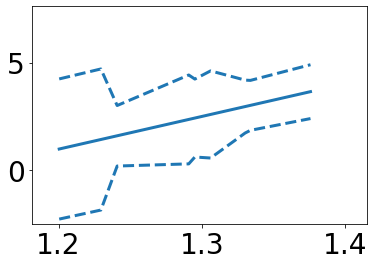

In [63]:
model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
results = model_WLS.fit()
plt.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
plt.xlim(ax.get_xlim())
plt.ylim(ax.get_ylim())
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
#ax.text(1.325,6,r"R$^{2}$="+f"{r2} ({pv})", color = 'C0')
print(results.summary())

In [22]:
model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
results = model_WLS.fit()
results.summary()

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.670
Model:                            WLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     14.21
Date:                Thu, 04 May 2023   Prob (F-statistic):            0.00699
Time:                        11:57:04   Log-Likelihood:                -8.3903
No. Observations:                   9   AIC:                             20.78
Df Residuals:                       7   BIC:                             21.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.3654      5.328     -3.259      0.014     -29.965      -4.766
x1            15.2741      4.052      3.769      0.007       5.692      24.856
==============================================================================
Omnibus:                        0.922   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.439
Skew:                           0.498   Prob(JB):                        0.803
Kurtosis:                       2.575   Cond. No.                         55.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model_WLS = sm.WLS(y, x, weights=model_ns_var_da.values)
results = model_WLS.fit()
results.summary()

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.914
Model:                            WLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                              85.33
Date:                Wed, 03 May 2023   Prob (F-statistic):                    1.53e-05
Time:                        12:03:48   Log-Likelihood:                         -12.545
No. Observations:                   9   AIC:                                      27.09
Df Residuals:                       8   BIC:                                      27.29
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0770      0.225      9.237      0.000       1.559       2.596
==============================================================================
Omnibus:                        3.239   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                1.363
Skew:                           0.951   Prob(JB):                        0.506
Kurtosis:                       2.875   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### without "outliers"

MIROC6
CNRM-CM6-1
INM-CM5-0
MPI-ESM1-2-HR
MPI-ESM1-2-LR
ERA5
UKESM1-0-LL
IPSL-CM6A-LR


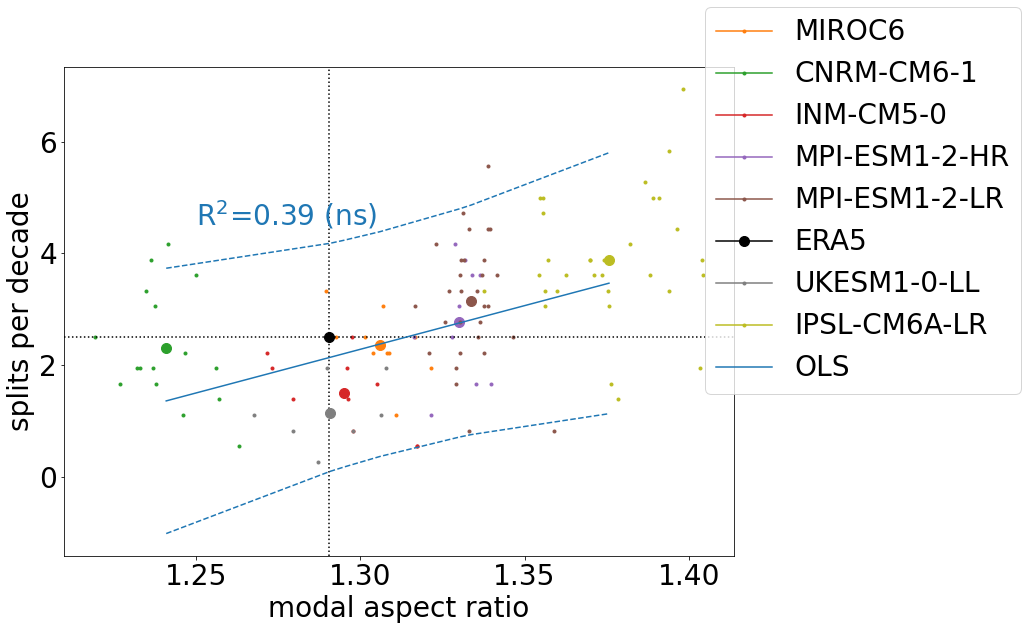

In [78]:
fig, ax = plt.subplots(figsize = (12,9))

model_ls_out=['CanESM5','CESM2-LE']#,'IPSL-CM6A-LR'] # ,

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []
for model, color in zip(diff_list(model_ls_new, model_ls_out), color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_split_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_aspect'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_split_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_aspect'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        
        x = np.mean(mode_ls)
        y= np.mean(ns_ls)
        y_var = np.var(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        model_ns_var_ls.append(xr.DataArray([y_var], coords = [('model', [model])]))
        ax.plot(x,y, marker = 'o', color = color,ms = ms)

model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')
        
x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T)
y = model_ns_da.values
# OLS
model_OLS = sm.OLS(y, x1)
results = model_OLS.fit()
order = np.argsort(model_mode_da)
ax.plot(x[order],results.fittedvalues[order], label = 'OLS')
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
plt.plot(x[order],iv_u[order], color = 'C0', ls="--")
plt.plot(x[order],iv_l[order], color = 'C0',ls="--")       
# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')

r2 = results.rsquared_adj.round(2)
pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
ax.text(1.25,4.5,r"R$^{2}$="+f"{r2} ({pv})", color = 'C0')
ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1.15))
plt.ylabel('splits per decade')
plt.xlabel('modal aspect ratio')
plt.savefig('split_frequency_vs_mode_wo-outliers.pdf',bbox_inches='tight')

In [79]:
results.summary()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     4.872
Date:                Thu, 04 May 2023   Prob (F-statistic):             0.0784
Time:                        14:27:16   Log-Likelihood:                -6.5587
No. Observations:                   7   AIC:                             17.12
Df Residuals:                       5   BIC:                             17.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.0035      9.270     -1.942      0.110     -41.833       5.826
x1            15.6078      7.071      2.207      0.078      -2.570      33.785
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.019
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.338
Skew:                          -0.230   Prob(JB):                        0.845
Kurtosis:                       2.027   Cond. No.                         69.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
results = model_WLS.fit()
results.summary()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.282
Model:                            WLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     1.571
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.278
Time:                        12:06:46   Log-Likelihood:                -5.0818
No. Observations:                   6   AIC:                             14.16
Df Residuals:                       4   BIC:                             13.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0931      9.245     -0.984      0.381     -34.762      16.576
x1             8.8984      7.099      1.253      0.278     -10.813      28.610
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.716
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.610
Skew:                          -0.240   Prob(JB):                        0.737
Kurtosis:                       1.514   Cond. No.                         73.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Displacements

CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
ERA5
CESM2-LE
CanESM5
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.218   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.107   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     1.955   \\
\textbf{Date:}             & Thu, 04 May 2023 & \textbf{  Prob (F-statistic):} &    0.205    \\
\textbf{Time:}             &     16:05:44     & \textbf{  Log-Likelihood:    } &   -15.260   \\
\textbf{No. Observations:} &           9      & \textbf{  AIC:               } &     34.52   \\
\textbf{Df Residuals:}     &           7      & \textbf{  BIC:               } &     34.91   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &   

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


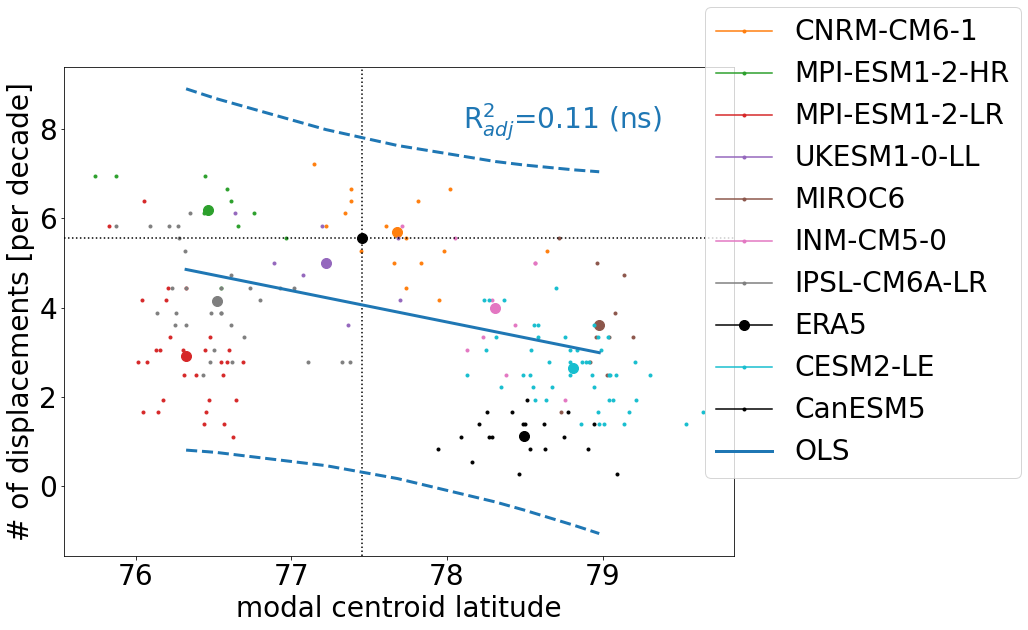

In [98]:
fig, ax = plt.subplots(figsize = (12,9))
wo_outliers = False

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []
for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_disp_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_latcent'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_disp_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_latcent'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        x = np.mean(mode_ls)
        y= np.mean(ns_ls)
        y_var = np.var(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        model_ns_var_ls.append(xr.DataArray([y_var], coords = [('model', [model])]))
        ax.plot(x,y, marker = 'o', color = color,ms = ms)

model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T) #  necessary, negative intercept is unphysical (frequancy of events cannot be <0)
y = model_ns_da.values
order = np.argsort(model_mode_da)


# OLS
if ols_calc:
    model_OLS = sm.OLS(y, x1)
    results = model_OLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'OLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)      
    print(results.summary().as_latex())
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[-1])#.round(3)
    ax.text(78.1,8,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    #ax.text(78.9,4.5,r"R$^{2}_{adj}$="+f"{r2}", color = 'C0')

if wls_calc:
    model_WLS = sm.WLS(y, x, weights=model_ns_var_da.values)
    results = model_WLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
    #ax.text(78.5,7,r"R$^{2}$="+f"{r2} ({pv})", color = 'C0')
    ax.text(78.9,7.75,r"R$^{2}$="+f"{r2}", color = 'C0')
    print(results.summary())

if wo_outliers:
    model_OLS = sm.OLS(y[:-how_many], x1[:-how_many])
    results = model_OLS.fit()
    order = np.argsort(model_mode_da[:-how_many])
    ax.plot(x[:-how_many][order],results.fittedvalues[order], label = f'OLS wo {how_many}', color = 'gray', lw = 3)
    
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[:-how_many][order],iv_u[order], color = 'gray', ls="--", lw = 3)
    plt.plot(x[:-how_many][order],iv_l[order], color = 'gray',ls="--", lw = 3)     
    
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
    ax.text(78.9,5,r"R$^{2}$="+f"{r2} ({pv})", color = 'gray')


# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')

ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1.15))
plt.ylabel('# of displacements [per decade]')
plt.xlabel('modal centroid latitude')
plt.savefig('displacement_frequency_vs_mode_all.pdf',bbox_inches='tight')

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            WLS   Adj. R-squared:                 -0.096
Method:                 Least Squares   F-statistic:                    0.2993
Date:                Thu, 04 May 2023   Prob (F-statistic):              0.601
Time:                        13:15:36   Log-Likelihood:                -14.184
No. Observations:                   9   AIC:                             32.37
Df Residuals:                       7   BIC:                             32.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.6938     30.584      0.677      0.5

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


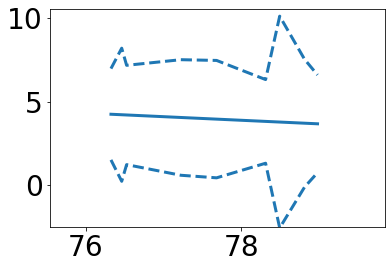

In [65]:
model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
results = model_WLS.fit()
plt.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
plt.xlim(ax.get_xlim())
plt.ylim(ax.get_ylim())
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
#ax.text(1.325,6,r"R$^{2}$="+f"{r2} ({pv})", color = 'C0')
print(results.summary())

In [55]:
np.corrcoef(y,x)

array([[ 1.       , -0.4672339],
       [-0.4672339,  1.       ]])

In [72]:
results.summary().as_latex()

'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}    &        y         & \\textbf{  R-squared:         } &     0.041   \\\\\n\\textbf{Model:}            &       WLS        & \\textbf{  Adj. R-squared:    } &    -0.096   \\\\\n\\textbf{Method:}           &  Least Squares   & \\textbf{  F-statistic:       } &    0.2993   \\\\\n\\textbf{Date:}             & Thu, 04 May 2023 & \\textbf{  Prob (F-statistic):} &    0.601    \\\\\n\\textbf{Time:}             &     13:18:41     & \\textbf{  Log-Likelihood:    } &   -14.184   \\\\\n\\textbf{No. Observations:} &           9      & \\textbf{  AIC:               } &     32.37   \\\\\n\\textbf{Df Residuals:}     &           7      & \\textbf{  BIC:               } &     32.76   \\\\\n\\textbf{Df Model:}         &           1      & \\textbf{                     } &             \\\\\n\\textbf{Covariance Type:}  &    nonrobust     & \\textbf{                     } &             \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{

In [70]:
temp()

/home/b/b381258/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


AttributeError: 'Summary' object has no attribute 'as_latex_tabular'

ERA5
MPI-ESM1-2-LR
UKESM1-0-LL
INM-CM5-0
MPI-ESM1-2-HR
MIROC6
CNRM-CM6-1


Text(0.5, 0, 'modal centroid latitude')

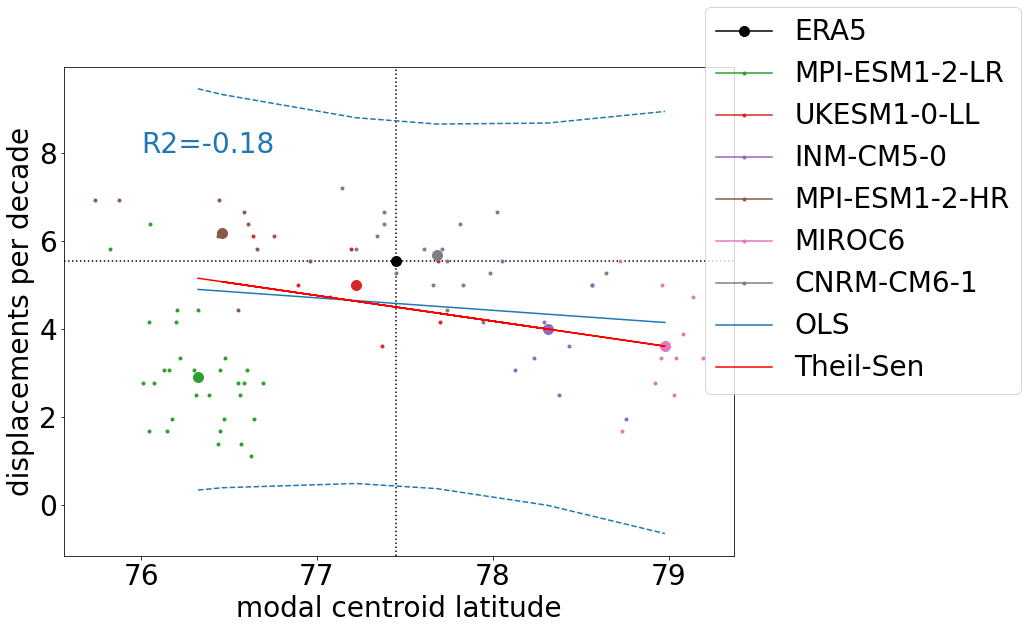

In [38]:
fig, ax = plt.subplots(figsize = (12,9))

model_mode_ls = []
model_ns_ls = []
for model, color in zip(diff_list(model_ls_new, model_ls_out), color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_disp_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_latcent'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_disp_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_latcent'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        x = np.mean(mode_ls)
        y= np.mean(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        ax.plot(x,y, marker = 'o', color = color,ms = ms)

model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T)
y = model_ns_da.values
# OLS
model_OLS = sm.OLS(y, x1)
results = model_OLS.fit()
order = np.argsort(model_mode_da)
ax.plot(x[order],results.fittedvalues[order], label = 'OLS')
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
plt.plot(x[order],iv_u[order], color = 'C0', ls="--")
plt.plot(x[order],iv_l[order], color = 'C0',ls="--")       
# Theil-Sen
res = stats.theilslopes(y,x)
ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')

ax.text(76,8,f"R2={results.rsquared_adj.round(2)}", color = 'C0')
ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1.15))
plt.ylabel('displacements per decade')
plt.xlabel('modal centroid latitude')
#plt.savefig('displacement_frequency_vs_mode.pdf',bbox_inches='tight')

In [37]:
results.summary()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                 -0.182
Method:                 Least Squares   F-statistic:                    0.2288
Date:                Tue, 02 May 2023   Prob (F-statistic):              0.657
Time:                        16:50:04   Log-Likelihood:                -9.2344
No. Observations:                   6   AIC:                             22.47
Df Residuals:                       4   BIC:                             22.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5651     45.984      0.578      0.594    -101.106     154.236
x1            -0.2838      0.593     -0.478      0.657      -1.931       1.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.785
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.401
Skew:                          -0.463   Prob(JB):                        0.818
Kurtosis:                       2.136   Cond. No.                     6.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""